<a href="https://colab.research.google.com/github/1stPtrp/BigData_project/blob/master/Project_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task 1: Import Packages and Functions

---



In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
import re
print(tf.__version__)

2.3.0


Task 2: Load and Explore Data

---



In [2]:
#!wget -O train.csv https://raw.githubusercontent.com/1stPtrp/BigData_project/master/train.csv

#!wget -O test.csv https://raw.githubusercontent.com/1stPtrp/BigData_project/master/test.csv

In [3]:
# Load Data
filePath = "/content/train.csv"
train_df = pd.read_csv(filePath).fillna(' ')
train_df.sample(10, random_state=1)

,id,keyword,location,text,target
3228,4632,emergency%20services,"Sydney, New South Wales",Goulburn man Henry Van Bilsen missing: Emergen...,1
3706,5271,fear,,The things we fear most in organizations--fluc...,0
6957,9982,tsunami,Land Of The Kings,@tsunami_esh ?? hey Esh,0
2887,4149,drown,,@POTUS you until you drown by water entering t...,0
7464,10680,wounds,"cody, austin follows ?*?",Crawling in my skin\nThese wounds they will no...,1
2539,3643,desolation,Istanbul,#np agalloch - the desolation song,0
6837,9794,trapped,,Hollywood Movie About Trapped Miners Released ...,1
7386,10570,windstorm,Houston,New roof and hardy up..Windstorm inspection to...,0
1506,2174,catastrophic,Inexpressible Island,The Catastrophic Effects of Hiroshima and Naga...,1
1875,2694,crush,Everywhere,tiffanyfrizzell has a crush: http://t.co/RaF73...,0


In [4]:
x = train_df['text'].values
print(x)

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'
 'Forest fire near La Ronge Sask. Canada'
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"
 ... 'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ'
 'Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.'
 'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d']


In [5]:
# View few text
train_df.loc[train_df['target']==1].sample(10, random_state=10)

,id,keyword,location,text,target
7239,10367,weapons,West,WWII Memories Plus Lessons of Hiroshima We Sti...,1
5789,8259,rioting,trapped in America,@evacide The Ferguson RIOTS worked. This of th...,1
3987,5664,floods,Australia,In #India 119000 people have taken shelter in ...,1
2184,3131,debris,,Aircraft debris found on island is from MH370 ...,1
5905,8433,sandstorm,USA,Watch This Airport Get Swallowed Up By A Sands...,1
300,442,apocalypse,,Shadow boxing the apocalypse,1
5694,8126,rescued,Earth,Migrants Rescued After Boat Capsizes Off Libya...,1
3112,4466,electrocuted,North Carolina,I'm loving this classic barn shot! We may or m...,1
863,1245,blood,,Can't believe more people in their mid 20's do...,1
5092,7264,nuclear%20disaster,"Ashford, Kent, United Kingdom",@emmerdale can we have a public vote for the n...,1


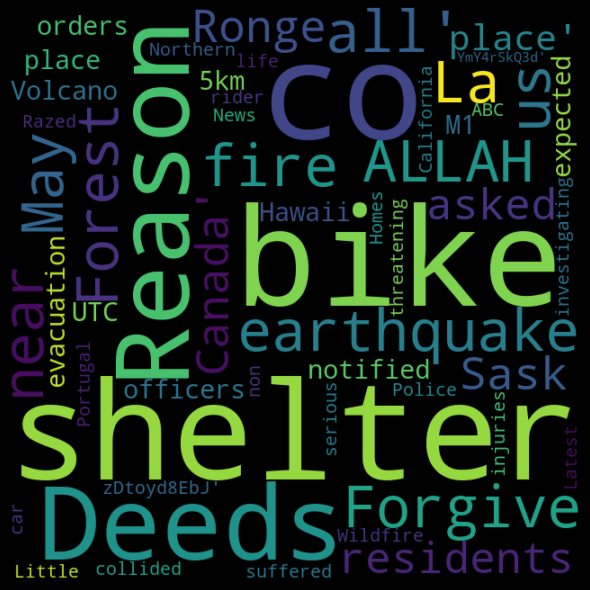

In [6]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
texts = train_df['text'].loc[train_df['target']==1].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(texts))
fig = plt.figure(
    figsize =(12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

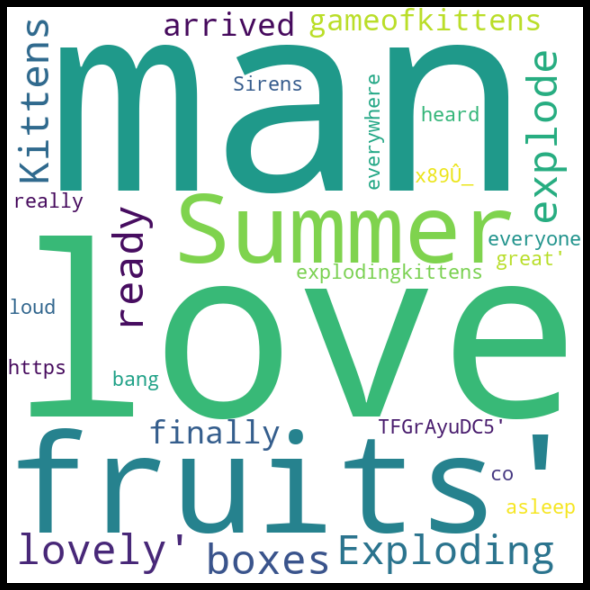

In [7]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
texts = train_df['text'].loc[train_df['target']==0].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(texts))
fig = plt.figure(
    figsize =(12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [8]:
y = train_df['target'].values
print(y)

[1 1 1 ... 1 1 1]


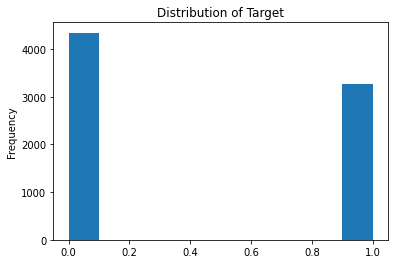

In [9]:
# Plot Frequency of target
train_df['target'].plot(kind='hist', title='Distribution of Target')

In [10]:
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

Task 3: Data Prep -- Tokenize and Pad Text Data

---



In [11]:
puncts = [
    ',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&',
    '/', '[', ']', '%', '=', '#', '*', '+', '\\', '•', '~', '@', '£',
    '·', '_', '{', '}', '©', '^', '®', '`', '→', '°', '€', '™', '›',
    '♥', '←', '×', '§', '″', '′', 'Â', '█', 'à', '…', '“', '★', '”',
    '–', '●', 'â', '►', '−', '¢', '¬', '░', '¶', '↑', '±',  '▾',
    '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '⊕', '▼',
    '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
    'è', '¸', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»',
    '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø',
    '¹', '≤', '‡', '₹', '´'
]

In [12]:
%%time
def clean_punct(x):
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, f' {punct} ')
    return x
train_df["text"] = train_df["text"].apply(lambda x: clean_punct(x))

CPU times: user 55.5 ms, sys: 2.93 ms, total: 58.4 ms
Wall time: 59.4 ms


In [13]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

In [14]:
train_df["text"] = train_df["text"].apply(lambda x: remove_URL(x))
train_df["text"] = train_df["text"].apply(lambda x: remove_emoji(x))
train_df["text"] = train_df["text"].apply(lambda x: remove_html(x))

In [15]:
max_features = 20000
max_text_length = 400

In [16]:
x_tokenizer = text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))
x_tokenized = x_tokenizer.texts_to_sequences(x)
x_train_val = sequence.pad_sequences(x_tokenized, maxlen=max_text_length)

Task 4: Prepare Embedding Matrix with Pre-trained GloVe Embeddings

---



In [17]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip

In [18]:
embedding_dim = 300
embeddings_index = dict()
f = open('/content/glove.6B.300d.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print(f'Found {len(embeddings_index)} word vectors.')

Found 400000 word vectors.


In [19]:
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, index in x_tokenizer.word_index.items():
  if index > max_features -1:
      break
  else:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector

Task 5:Create the Embedding Layer

---



In [20]:
model = Sequential()
model.add(Embedding(max_features,
                    embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(
                    embedding_matrix),
                    trainable=False))
model.add(Dropout(0.2))

Task 6: Build the Model

---



In [21]:
filters = 250
kernel_size = 3
hidden_dims = 250

In [22]:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid'))
model.add(MaxPooling1D())
model.add(Conv1D(filters,
                 5,
                 padding='valid',
                 activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         6000000   
_________________________________________________________________
dropout (Dropout)            (None, None, 300)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 250)         225250    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 250)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 250)         312750    
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               6

In [23]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Task 7: Train Model

---



In [24]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y,
                                                  test_size=0.15, random_state=1)

In [25]:
%%time
batch_size = 32
epochs = 3

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data= (x_val, y_val))

Epoch 1/3
203/203 [==============================] - 111s 548ms/step - loss: 0.4829 - accuracy: 0.7762 - val_loss: 0.5283 - val_accuracy: 0.7811
Epoch 2/3
203/203 [==============================] - 111s 549ms/step - loss: 0.4084 - accuracy: 0.8184 - val_loss: 0.4407 - val_accuracy: 0.7951
Epoch 3/3
203/203 [==============================] - 112s 552ms/step - loss: 0.3645 - accuracy: 0.8394 - val_loss: 0.4575 - val_accuracy: 0.8056
CPU times: user 10min 36s, sys: 6.43 s, total: 10min 42s
Wall time: 5min 37s


Task 8:Evaluate Model

---



In [26]:
val_predictions = model.predict(x_val, verbose=1, batch_size=32)

36/36 [==============================] - 6s 167ms/step


In [27]:
val_predictions.shape

(1142, 1)

In [28]:
val_predictions

array([[0.3378745 ],
       [0.28963518],
       [0.29521334],
       ...,
       [0.02491742],
       [0.9971516 ],
       [0.8853066 ]], dtype=float32)

In [29]:
from sklearn import metrics
import seaborn as sns

val_predictions_int = val_predictions.round().astype('int')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [33]:
# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

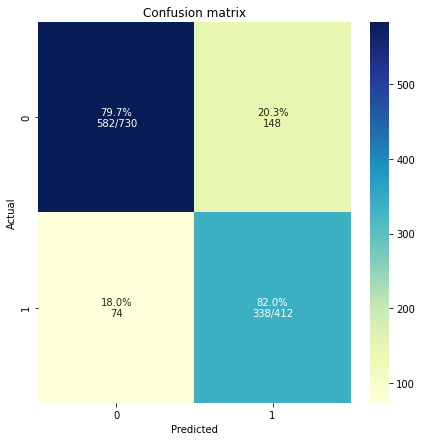

In [39]:
from sklearn.metrics import classification_report,confusion_matrix
# Showing Confusion Matrix
plot_cm(val_predictions_int, y_val, 'Confusion matrix', figsize=(7,7))

In [35]:
#Import Test dataset
test_df = pd.read_csv('/content/test.csv')

In [36]:
test_df.shape

(3263, 4)

In [37]:
test_df["text"] = test_df["text"].apply(lambda x: clean_punct(x))
test_df["text"] = test_df["text"].apply(lambda x: remove_URL(x))
test_df["text"] = test_df["text"].apply(lambda x: remove_emoji(x))
test_df["text"] = test_df["text"].apply(lambda x: remove_html(x))

In [38]:
x_test = test_df['text'].values

In [40]:
def predict_writesub(x_test):
    x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)
    x_testing = sequence.pad_sequences(x_test_tokenized, maxlen=max_text_length)
    predictions = model.predict(x_testing, verbose=1, batch_size=32)
    submission = pd.DataFrame({'id': test_df['id'], 'target': predictions.ravel()})
    submission['target'] = np.where(submission['target']  > 0.5, 1, 0)
    submission.to_csv('submit.csv', index = False)
    print(submission.head())
    
predict_writesub(x_test)

102/102 [==============================] - 17s 171ms/step
   id  target
0   0       0
1   2       1
2   3       1
3   9       0
4  11       1


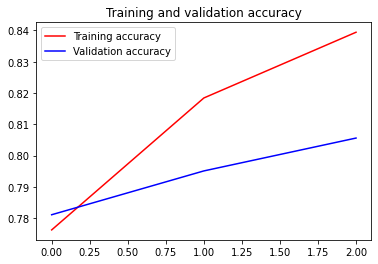

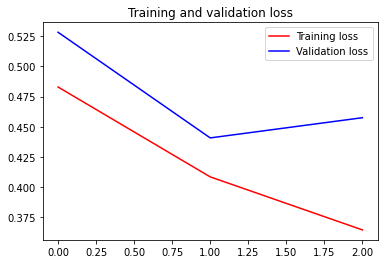

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()